# Wine review NLP

We try to predict the point given by critics based on their description of the wine. 

- We use the term frequency - inverse document frequency (tf-idf) to generate features to analyze the data

- We do a weighted stochastic linear regression on the features and the points to fit the data.

    - Batch gradient descent has to be used because the dataset is too high dimensional. 
    - The sample data needs to be weighted because the points are distributed heavily around the mean value.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 9.0)

## Import and preprocess data

In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
print (df.shape)

(129971, 13)


In [3]:
df['desc_len'] = df['description'].apply(len)

In [4]:
df.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_len
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,172
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,227


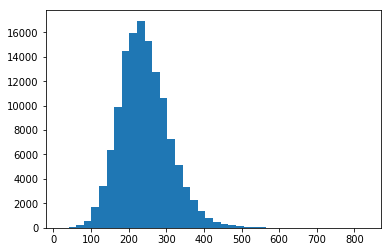

In [5]:
u = plt.hist(df.desc_len, bins=40)

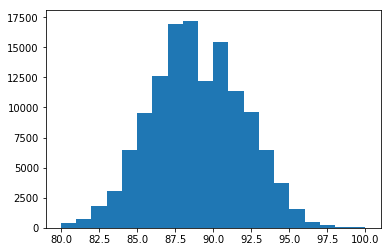

In [6]:
u = plt.hist(df.points, bins=20)

### Remove duplicate entries

In [7]:
m = df.shape[0]
print('Percentage of duplicate entries {:.1f}%'.format(100*(m - df.description.nunique())/m))

Percentage of duplicate entries 7.7%


In [8]:
cnts = df.description.value_counts()
cnts[cnts > 1]

# Check if the duplicate descriptions refer to the same wine
text = cnts.index[0]
df[df.description == text]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_len
53296,Italy,"Ripe plum, game, truffle, leather and menthol ...",NaN,88,72.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,La Mannella 2011 Brunello di Montalcino,Sangiovese,La Mannella,254
126592,Italy,"Ripe plum, game, truffle, leather and menthol ...",NaN,88,72.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,La Mannella 2011 Brunello di Montalcino,Sangiovese,La Mannella,254
126930,Italy,"Ripe plum, game, truffle, leather and menthol ...",NaN,87,40.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,Poggiarellino 2011 Brunello di Montalcino,Sangiovese,Poggiarellino,254


In [9]:
# Drop rows that have the same description
df = df.drop_duplicates(subset='description')
df.shape

(119955, 14)

## TF-IDF feature generation

In [10]:
""" Feature engineering:
Use Term Frequency - Inverse Document Frequency (TF-IDF) to create features
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [11]:
X = df.description
point_mean = df.points.mean()
point_std = df.points.std()
y = (df.points - point_mean) / point_std

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(83968,)
(35987,)


In [12]:
# Generate tf-idf

n = 3
tfv = TfidfVectorizer(min_df=3, # minimum document frequency of the word
                      max_features=None,
                      strip_accents='unicode', # strip accents from unicode characters
                      analyzer='word',
                      token_pattern=r'\w{1,}', # alphanumeric character + 1 or more repetition?
                      ngram_range=(1,n), # make vocabulary with 1 to 3 words ngram
                      use_idf=1, # use inverse document frequency
                      smooth_idf=1, 
                      sublinear_tf=1,
                      stop_words = 'english'
                     )

start = time.time()
X_train_vect = tfv.fit_transform(X_train)
end = time.time()
print('Time to train vectorizer and transform training text: %0.2fs' % (end - start))

Time to train vectorizer and transform training text: 11.99s


## Model fit: without sample_weight

In [13]:
# I was using a LinearRegression previously, but with the wider vocab it's too slow. 
# Let's use the SGDRegressor with ordinary least squares.
# Also, using mean squared error as the eval metric, since negative values crash mean squared log error.

model = SGDRegressor(loss='squared_loss', max_iter=5)
params = {'penalty':['none','l1','l2'],
          'alpha': np.logspace(-4, -1, 5)}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=5)

start = time.time()
gs.fit(X_train_vect, y_train)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))

Time to train model: 7.56s


In [14]:
model = gs.best_estimator_
print(gs.best_params_)
print(gs.best_score_)

{'alpha': 0.0005623413251903491, 'penalty': 'none'}
-0.8487748625527807


In [15]:
pipe = Pipeline([('vect', tfv), ('model', model)])
start = time.time()
y_pred = pipe.predict(X_test)
end = time.time()

print('Time to generate predictions on test set: %0.2fs' % (end - start))

Time to generate predictions on test set: 1.99s


In [16]:
print(point_std * mean_squared_error(y_test, y_pred))

2.5242843322869195


(array([ 328.,  557.,  904., 1923., 2665., 3464., 4559., 4615., 3350.,
        4178., 3193., 2683., 1780., 1077.,  472.,  152.,   52.,   17.,
          18.]), array([ 80.        ,  81.05263158,  82.10526316,  83.15789474,
         84.21052632,  85.26315789,  86.31578947,  87.36842105,
         88.42105263,  89.47368421,  90.52631579,  91.57894737,
         92.63157895,  93.68421053,  94.73684211,  95.78947368,
         96.84210526,  97.89473684,  98.94736842, 100.        ]), <a list of 19 Patch objects>)

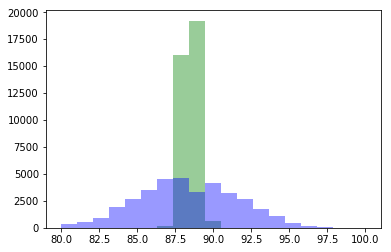

In [17]:
plt.hist(y_pred * point_std + point_mean, bins=np.linspace(80, 100, 20), alpha=0.4, color='g')
plt.hist(y_test * point_std + point_mean, bins=np.linspace(80, 100, 20), alpha=0.4, color='b')

If we don't use sample weights, the model simply predicts average value.

In [18]:
# Build a list of vocabulary outputs of tf-idf vectorizer
import operator
sorted_dict = sorted(tfv.vocabulary_.items(), key=operator.itemgetter(1))
indices_word = list(list(zip(*sorted_dict))[0])

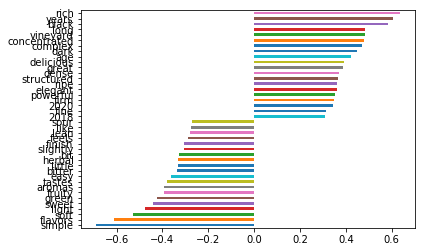

In [19]:
coef = pd.Series(model.coef_, index = indices_word)
num_coef = 20
imp_coef = pd.concat([coef.sort_values().head(num_coef),
                      coef.sort_values().tail(num_coef)])

plt.figure()
imp_coef.plot(kind='barh')

The cofficients to the linear regression model confirms that the words chosen are rather random.

## Model fit: with sample_weight

In [20]:
## Model fit: without sample_weight
model2 = SGDRegressor(loss='squared_loss', max_iter=5)
params = {'penalty':['none','l2'],
          'alpha': np.logspace(-4, -1, 5)}
gs2 = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=5)

start = time.time()
gs2.fit(X_train_vect, y_train, sample_weight=10*np.abs(y_train)**2 + 0.02)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))

Time to train model: 4.22s


In [21]:
model2 = gs2.best_estimator_
print(gs2.best_params_)
print(gs2.best_score_)

{'alpha': 0.0031622776601683794, 'penalty': 'l2'}
-0.44246980947734066


In [22]:
pipe2 = Pipeline([('vect', tfv), ('model', model2)])
start = time.time()
y_pred2 = pipe2.predict(X_test)
end = time.time()

print('Time to generate predictions on test set: %0.2fs' % (end - start))

Time to generate predictions on test set: 2.07s


In [23]:
print(point_std * mean_squared_error(y_test, y_pred2))

1.3690456904026596


1.3690456904026596


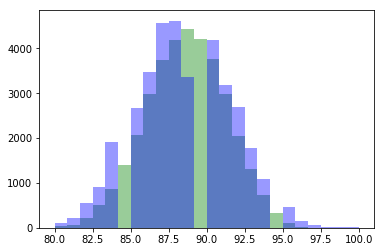

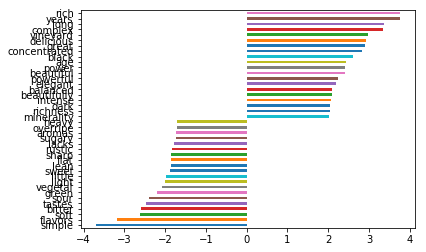

In [24]:
print(point_std * mean_squared_error(y_test, y_pred2))

plt.hist(y_pred2 * point_std + point_mean, bins=np.linspace(80, 100, 25), alpha=0.4, color='g')
plt.hist(y_test * point_std + point_mean, bins=np.linspace(80, 100, 25), alpha=0.4, color='b')

coef = pd.Series(model2.coef_, index = indices_word)
num_coef = 20
imp_coef = pd.concat([coef.sort_values().head(num_coef),
                      coef.sort_values().tail(num_coef)])

plt.figure()
imp_coef.plot(kind='barh')